# Quantization
The default behavior of the converter is to optimize for both size and latency, but you can override this in code. We'll see that next. So here's an example of where we override the default behavior of the converter to optimize primarily for size. You could also specify that you want to optimize for latency for improved performance or just leave it at the default where the converter will try to figure out the best balance between size and latency.

In [ ]:
# Example 1 : Post-training quantization
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

tflite_quant_model = converter.convert()

In [ ]:
# Example 2 : Post-training integer quantization
def generator():
    data = tfds.load(...)
    for _ in range(num_calibration_steps):
        image, = data.take(1)
        yield [image]

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

# Set the optimization mode
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Pass the representative dataset to the converter
converter.representative_dataset = tf.lite.RepresentativeDataset(generator)
'''
A representative data set is used for evaluating optimizations by recording dynamic ranges. 
This is done by running multiple inferences on a floating point TensorFlow Lite model 
using the user provided representative data set as an input. We can then use the 
values log from inferences to determine the scaling parameters needed to execute 
all tensors of the model in integer arithmetic. This makes the model allow 
the activations to be quantized along with the weights. The resulting model will have 
as many quantized ops as possible. For ops that don't have a quantized implementation, 
they'll fall back to float ones, thereby allowing the model to still take flow input 
and output for convenience.
'''

# Restricting supported target op specification to INT8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILINTS_INT8]
'''
If you have ops that don't have quantized implementations, their floating values 
will be used automatically. This makes for conversions to occur smoothly while 
restricting deployments as special purpose accelerators that only support integers. 
So to support these devices that do not support floating point operations, 
we just tell the converter to only output integers, and this can be done by 
constraining the quantization target specification to TFLITE_BUILINTS_INT8 built-in ops. 
Do note that if the converter comes across an operation which cannot be currently 
quantized, an error may be raised.
'''

# TF-Select

Conversion can sometimes be harder as you might come across some problems with unsupported TensorFlow Ops while converting your models with the TF lite converter. This means the framework supports a limited number of TensorFlow operations used in common inference models as that process by the Tensorflow lite optimizing converter. These operations may be avoided or fused before the supported operations are mapped to their TensorFlow lite counterparts. Since the set of TensorFlow lite operations is smaller than TensorFlow's regular C++ Ops, not every model is convertible. Even for supported operations, very specific usage patterns are sometimes expected for performance reasons. It is expected that more sets of operations will be supported in future TensorFlow lite releases. For the list of all supported operations, go visit this URL http://www.tensorflow.org/lite/guide/ops_select In the model conversion process, Those unsupported Ops can come off as point of friction. While TensorFlow lite will continue to have the built-in Ops optimized for mobile and embedded devices, now it's possible to use a subset of the TensorFlow Ops when the built-in ones do not suffice. With TF select, you can do this, keeping in mind that a small bulk will be added to your model's.

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                        tf.lite.OpsSet.SELECT_TF_OPS]

tflite_mode = converter.convert()


https://www.tensorflow.org/lite/guide/ops_compatibility

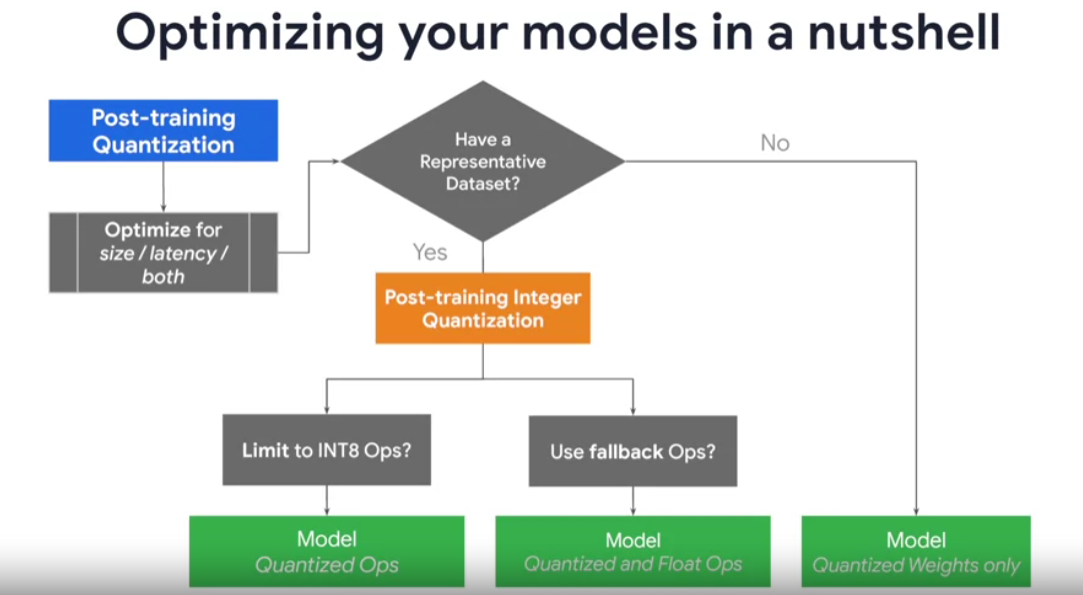

This is a summary of the paths you're likely to follow when optimizing your TF Lite models. If you don't intend to quantize your model, you'll be ending up with a floating point model. However, if you do wish to quantize only the weights in the model, you can do so just by setting one of the post-training optimization modes in the converter. The converter will do its best to quantize all the ops, but your model may still end up with a few floating point ops. This optimization provides latencies close to fully fixed point inference. We can further get latency improvements by quantizing both the weights and activations with a representative dataset. On a side note, at times you may not have access to a representative dataset, and you don't have to worry too much about it as you can get along just fine without it by having a model that has some floating point ops. Later, if you wish to have the model only output integers, a quantization target specification can be set in the converter to generate a model with quantized ops. But if all else fails and you're encountering errors in this procedure, then you might have to use TF select to obtain a model with as many ops as possible.

# TensorFlow Lite Interpreter in Python
One really nice feature is the ability to test your model using Python on your developer workstation so you don't need to deploy it to a mobile and embedded system before you can start using it.

In [ ]:
# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Point the data to be used for testing and run the interpreter
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])